In [182]:
from dotenv import load_dotenv
# Library that has a lot of operating system functions
from os import getenv
import requests
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import panel as pn

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

import string
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import pymongo
import json
import param

In [2]:
# Load from the .env
load_dotenv()

# Get the Reddit credentials from environmental variables
APP_NAME = getenv('APP_NAME')
APP_ID = getenv("APP_ID")
APP_SECRET = getenv("APP_SECRET")
USERNAME = getenv('REDDIT_USERNAME')
PASSWORD = getenv('PASSWORD')

In [3]:
# Check that the variables all loaded
if APP_NAME and APP_ID and APP_SECRET and USERNAME and PASSWORD:
    print("Credentials loaded")
else:
    print("ERROR: Credentials not loaded!!")

Credentials loaded


In [4]:
# Sets up the authentication part of the request
auth = requests.auth.HTTPBasicAuth(f'{APP_ID}', f'{APP_SECRET}')

# Sets up the data we want to send: our login method (password), username, and password
data = {'grant_type': 'password',
        'username': f'{USERNAME}',
        'password': f'{PASSWORD}'}

# Sets up this requests header info, which gives reddit a brief description of our app
# This is the format requested by Reddit: os:app_name:version (by /u/username)
headers = {'User-Agent': f'macos:{APP_NAME}:v1.0 (by /u/{USERNAME})'}

# Makes the request to the access_token api endpoint, and saves the response in res
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)

# Converts response to JSON and pull access_token value
TOKEN = res.json()['access_token']

# Adds authorisation to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# While the token is valid (~2 hours) we can just add headers=headers to our requests to prove authentication
# Making a test request. <Response [200]> means that it was a success!
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

<Response [200]>

### Creating Functions for reusability
After writing the code lines one-by-one and verifying the correctness, organizing the code into functions for better reusuability and correctness.

In [5]:
# Function to search Reddit posts
def search_reddit(subreddit, keyword):
    # Searching for a keyword within sub-reddit for last 1 year and sort by comments
    # https://www.reddit.com/dev/api#GET_search
    params = {'limit': 100, 'restrict_sr': 1, 'sr_nsfw': 1, 't': 'all', 'sort': 'comments'}
    search_results = []

    for i in range(100):
        res = requests.get(
            f"https://oauth.reddit.com/r/{subreddit}/search?q={keyword}",
            headers=headers,
            params=params
        )

        results = res.json()['data']['children']
        search_results.extend(results)

        # Get the ID of last post and start next search after it
        try:
            fullname = f"{results[-1]['kind']}_{results[-1]['data']['id']}"
            # This tells the API that the post we want is the one after the current one in the queue (ie is the next oldest one).
            params['after'] = fullname
            # Sleeping for 1 second to not exceed Reddit's API limits
            time.sleep(1)
        except:
            print(f"No search results after last result ID: {params['after']}")
            break

    # Total search results for the keyword
    print(f"Search results: {len(search_results)}")
    return get_comments_for_posts(search_results)


# Function to get comments/replies for each post
def get_comments_for_posts(search_results):
    # Define a list to store all the post and comment responses
    comments = []
    for post in search_results:
        # Get comments for each post
        res = requests.get(
            f"https://oauth.reddit.com{post['data']['permalink']}",
            headers=headers
        )
        # Add the retreived post body
        post = res.json()[0]['data']['children'][0]['data']
        replies = res.json()[1]['data']['children']
        comments.append({'created_utc': post['created_utc'],
                      'author': post['author'],
                      'post_id': post['id'],
                      'subreddit': post['subreddit'],
                     'text': post['selftext']})
        # Add the retreived comments to "comments" list
        # Loop through the comments and extract the reply bodies
        for comment in replies:
            reply_bodies = extract_reply_body(comment)
            if reply_bodies:
                comments.append(reply_bodies)
        
        # Sleeping for 0.1 second to not exceed Reddit's API limits
        time.sleep(0.1)

    print(f"Total comments retreived: {len(comments)}")
    return comments
    
# Define a function to extract the reply body from a comment or a reply
# It takes reply as input and returns its body or list of bodies
def extract_reply_body(reply):
    if reply['kind'] == 't1':
        # If the reply is a comment, extract the comment body
        return {
            'created_utc': reply['data']['created'],
            'author': reply['data']['author'],
            'post_id': reply['data']['link_id'].split('_')[1],
            'subreddit': reply['data']['subreddit'],
            'text': reply['data']['body']
        }
    elif reply['kind'] == 'Listing':
        # If the reply is a listing of replies, traverse the listing and extract the reply bodies
        reply_bodies = []
        for child in reply['data']['children']:
            reply_body = extract_reply_body(child)
            if reply_body:
                reply_bodies.append(reply_body)
        return reply_bodies

In [6]:
# Creating DF from search results for "house contruction" in Reddit
irish_construction_posts_df = pd.DataFrame.from_dict(search_reddit("ireland", "house construction"))
irish_construction_posts_df.head()

No search results after last result ID: t3_rtkitj
Search results: 131
Total comments retreived: 1792


,created_utc,author,post_id,subreddit,text
0,1.674811e+09,tashadaily,10mgkxn,ireland,Right so obviously a burner account.\n\nMy fia...
1,1.674818e+09,PedantJuice,10mgkxn,ireland,"First; this is perfectly, perfectly human way ..."
2,1.674814e+09,FullyStacked92,10mgkxn,ireland,The reason your life isn't comfortable on a co...
3,1.674817e+09,theriskguy,10mgkxn,ireland,"You’re directing your anger in the wrong, dire..."
4,1.674812e+09,slice_of_za,10mgkxn,ireland,Sounds like you're having a shitty time of it ...


In [7]:
irish_construction_posts_df['created_utc'] = pd.to_datetime(irish_construction_posts_df['created_utc'], unit='s')
irish_construction_posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792 entries, 0 to 1791
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   created_utc  1792 non-null   datetime64[ns]
 1   author       1792 non-null   object        
 2   post_id      1792 non-null   object        
 3   subreddit    1792 non-null   object        
 4   text         1792 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 70.1+ KB


In [8]:
irish_construction_posts_df.head()

,created_utc,author,post_id,subreddit,text
0,2023-01-27 09:09:44,tashadaily,10mgkxn,ireland,Right so obviously a burner account.\n\nMy fia...
1,2023-01-27 11:15:03,PedantJuice,10mgkxn,ireland,"First; this is perfectly, perfectly human way ..."
2,2023-01-27 09:59:22,FullyStacked92,10mgkxn,ireland,The reason your life isn't comfortable on a co...
3,2023-01-27 10:59:06,theriskguy,10mgkxn,ireland,"You’re directing your anger in the wrong, dire..."
4,2023-01-27 09:36:50,slice_of_za,10mgkxn,ireland,Sounds like you're having a shitty time of it ...


In [9]:
# Creating DF from search results for "house contruction" in Reddit
irish_housing_posts_df = pd.DataFrame.from_dict(search_reddit("ireland", "housing"))
irish_housing_posts_df.head()

No search results after last result ID: t3_tpgxq4
Search results: 230
Total comments retreived: 14696


,created_utc,author,post_id,subreddit,text
0,1.663774e+09,coluber_,xk7udf,ireland,Hi all. I see the topic of Ukrainian refugees ...
1,1.663774e+09,pul123PUL,xk7udf,ireland,What has been the biggest challenge for you da...
2,1.663780e+09,Fantastic_Section517,xk7udf,ireland,Are you working at present? The reason I ask i...
3,1.663777e+09,EDITORDIE,xk7udf,ireland,I wish you and your family the best and hope t...
4,1.663774e+09,ImpressionPristine46,xk7udf,ireland,Have all your family and friends moved to Irel...


In [10]:
# Converting to datetime
irish_housing_posts_df['created_utc'] = pd.to_datetime(irish_housing_posts_df['created_utc'], unit='s')
irish_housing_posts_df.head()

,created_utc,author,post_id,subreddit,text
0,2022-09-21 15:21:22,coluber_,xk7udf,ireland,Hi all. I see the topic of Ukrainian refugees ...
1,2022-09-21 15:29:39,pul123PUL,xk7udf,ireland,What has been the biggest challenge for you da...
2,2022-09-21 17:06:30,Fantastic_Section517,xk7udf,ireland,Are you working at present? The reason I ask i...
3,2022-09-21 16:12:04,EDITORDIE,xk7udf,ireland,I wish you and your family the best and hope t...
4,2022-09-21 15:30:34,ImpressionPristine46,xk7udf,ireland,Have all your family and friends moved to Irel...


In [87]:
# Combining two DFs
irish_housing_reddit_df = pd.concat([irish_construction_posts_df, irish_housing_posts_df])
irish_housing_reddit_df.shape

(16488, 5)

In [88]:
# Check the duplicates after concatenating two DFs
irish_housing_reddit_df.duplicated(subset=['created_utc']).sum()

291

In [89]:
# Drop the duplicates
irish_housing_reddit_df.drop_duplicates(subset=['created_utc'], inplace=True)
irish_housing_reddit_df.shape

(16197, 5)

### Data Pre Processing and Sentiment Analysis

In [65]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [90]:
# Function to clean data before Sentiment Analysis
def get_cleaned_data(X):
    # Store the stopwords into the object named as "stop_words"
    stop_words = stopwords.words('english')

    # Store the string.punctuation into an object punct
    punct = string.punctuation

    # Initialise an object using a method PorterStemmer
    stemmer = PorterStemmer()

    cleaned_data=[]

    # For loop from first value to length(X), ^a-zA-Z means include small and capital case letters
    for i in range(len(X)):
        post = re.sub('[^a-zA-Z]', ' ', X.iloc[i])
        post = post.lower().split()
        post = [stemmer.stem(word) for word in post if (word not in stop_words) and (word not in punct)]
        post = ' '.join(post)
        cleaned_data.append(post)

    return pd.Series(cleaned_data)


# Function to classify compound result 
def classify_sia_polarity(output_dict):  
    polarity = "neutral"

    if(output_dict['compound'] >= 0.05):
        polarity = "positive"

    elif(output_dict['compound'] <= -0.05):
        polarity = "negative"

    return polarity

# Function to classify textblob's sentiment polarity
def classify_textblob_polarity(polarity):
    sentiment = "neutral"
    if(polarity > 0):
        sentiment = "positive"
    elif(polarity < 0):
        sentiment = "negative"
    return sentiment

# Function to predict sentiment
def predict_sentiment(text): 
    output_dict =  sia.polarity_scores(text)
    return classify_sia_polarity(output_dict)

# Function to calculate sentiment polarity using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = classify_textblob_polarity(blob.sentiment.polarity)
    return sentiment

In [91]:
cleaned_data = get_cleaned_data(irish_housing_reddit_df['text'])
irish_housing_reddit_df['vader_prediction'] = cleaned_data.apply(predict_sentiment)
irish_housing_reddit_df['textblob_sentiment'] = cleaned_data.apply(get_sentiment)

In [92]:
irish_housing_reddit_df.tail()

,created_utc,author,post_id,subreddit,text,vader_prediction,textblob_sentiment
14691,2022-03-28 02:35:38,wolflors,tpgxq4,ireland,You're right. If the person two doors down is ...,positive,negative
14692,2022-03-28 06:43:15,Mean_Mud_4009,tpgxq4,ireland,"Just face it, they might just not you near the...",positive,positive
14693,2022-03-28 09:39:18,CompetitionOk3883,tpgxq4,ireland,Unfortunately I don't think people that do tha...,positive,positive
14694,2022-03-28 10:04:47,Electronic_Dress975,tpgxq4,ireland,Dont care about my property price but some of ...,negative,positive
14695,2022-03-28 16:45:38,davsheep,tpgxq4,ireland,"Well, this thread didn't go the way op expected.",neutral,neutral


In [93]:
print(f"Differences between Vader and TextBlob: {irish_housing_reddit_df[irish_housing_reddit_df['vader_prediction'] != irish_housing_reddit_df['textblob_sentiment']].shape[0]}")

Differences between Vader and TextBlob: 5679


[Text(0.5, 1.0, 'TextBlob Prediction')]

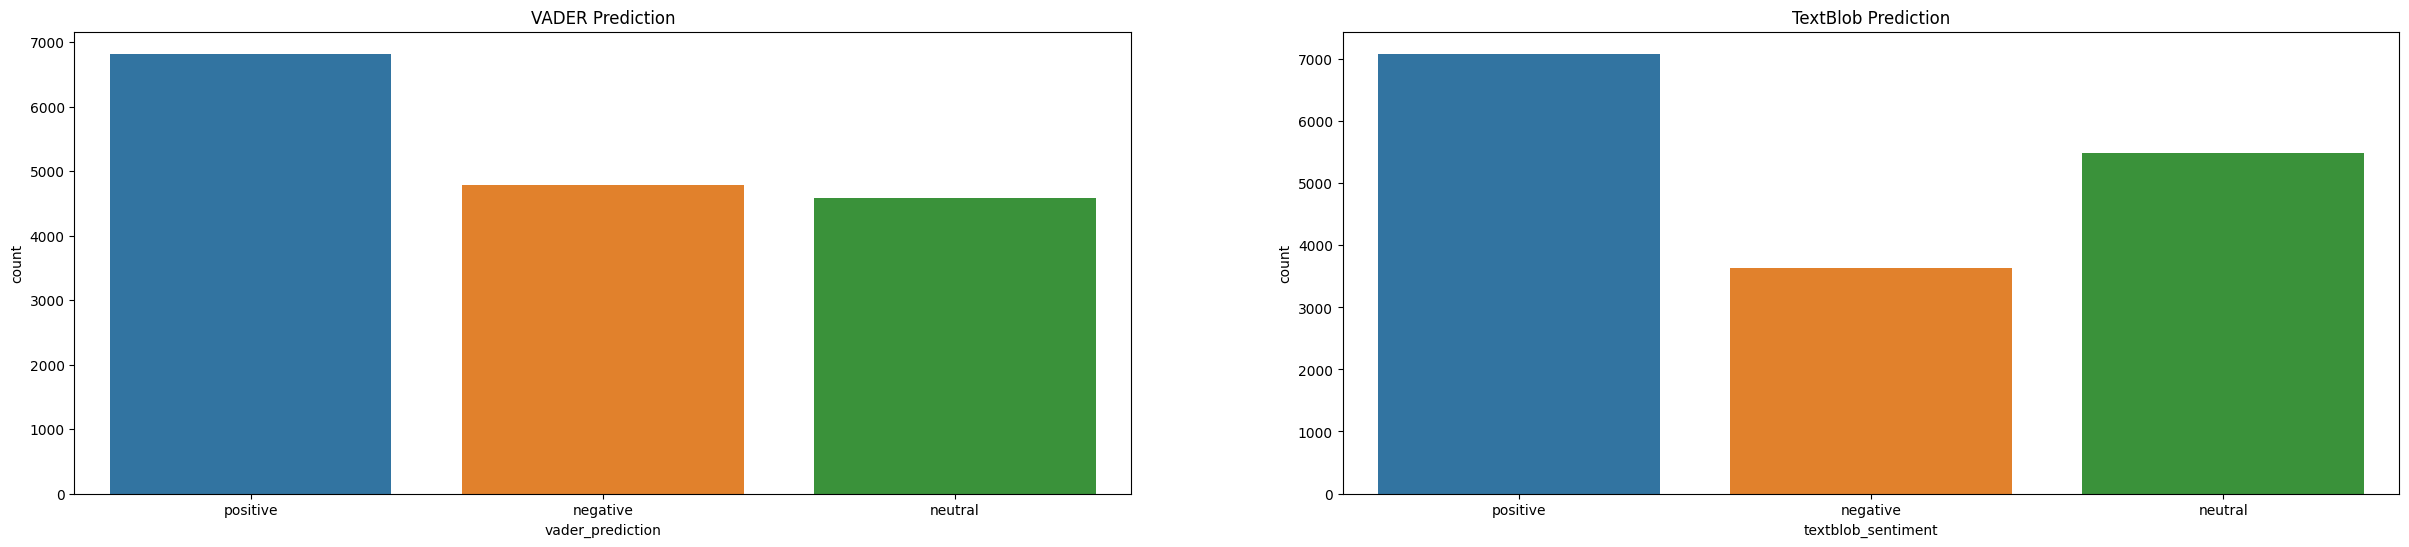

In [94]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(30,6))
sns.countplot(data=irish_housing_reddit_df, x='vader_prediction', ax=ax1).set(title="VADER Prediction")
sns.countplot(data=irish_housing_reddit_df, x='textblob_sentiment', ax=ax2).set(title="TextBlob Prediction")

### European house construction sentiment

In [98]:
# Create a DF with Reddit search data for "house construction" in subreddit "europe"
europe_house_cons_reddit_df = pd.DataFrame.from_dict(search_reddit("europe", "house construction"))

No search results after last result ID: t3_1gfkaa
Search results: 34
Total comments retreived: 363


In [99]:
europe_housing_reddit_df = pd.DataFrame.from_dict(search_reddit("europe", "housing"))

No search results after last result ID: t3_gf554j
Search results: 215
Total comments retreived: 6972


In [100]:
european_housing_reddit_df = pd.concat([europe_house_cons_reddit_df, europe_housing_reddit_df])
european_housing_reddit_df.shape

(7335, 5)

In [101]:
# Drop the duplicates
european_housing_reddit_df.drop_duplicates(subset=['created_utc'], inplace=True)
european_housing_reddit_df.shape

(7163, 5)

In [102]:
european_housing_reddit_df['created_utc'] = pd.to_datetime(european_housing_reddit_df['created_utc'], unit='s')
european_housing_reddit_df.head()

,created_utc,author,post_id,subreddit,text
0,2021-10-07 18:19:16,DevilSauron,q3f6wi,europe,**The Election**\n\nTomorrow and on Saturday (...
1,2021-10-14 13:58:01,Plane_Willingness_25,q3f6wi,europe,So how are things developing? Is Babis still g...
2,2021-10-09 22:57:31,linknewtab,q3f6wi,europe,Any chance the new government will finally joi...
3,2021-10-09 22:55:50,[deleted],q3f6wi,europe,[deleted]
4,2021-10-09 22:48:07,Freeman3017,q3f6wi,europe,"Victory day for democracy, this is how it shou..."


In [104]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

cleaned_data = get_cleaned_data(european_housing_reddit_df['text'])
european_housing_reddit_df['vader_prediction'] = cleaned_data.apply(predict_sentiment)
european_housing_reddit_df['textblob_sentiment'] = cleaned_data.apply(get_sentiment)
european_housing_reddit_df.head()

,created_utc,author,post_id,subreddit,text,vader_prediction,textblob_sentiment
0,2021-10-07 18:19:16,DevilSauron,q3f6wi,europe,**The Election**\n\nTomorrow and on Saturday (...,positive,positive
1,2021-10-14 13:58:01,Plane_Willingness_25,q3f6wi,europe,So how are things developing? Is Babis still g...,neutral,neutral
2,2021-10-09 22:57:31,linknewtab,q3f6wi,europe,Any chance the new government will finally joi...,positive,positive
3,2021-10-09 22:55:50,[deleted],q3f6wi,europe,[deleted],neutral,neutral
4,2021-10-09 22:48:07,Freeman3017,q3f6wi,europe,"Victory day for democracy, this is how it shou...",negative,positive


In [105]:
print(f"Differences between Vader and TextBlob: {european_housing_reddit_df[european_housing_reddit_df['vader_prediction'] != european_housing_reddit_df['textblob_sentiment']].shape[0]}")

Differences between Vader and TextBlob: 2447


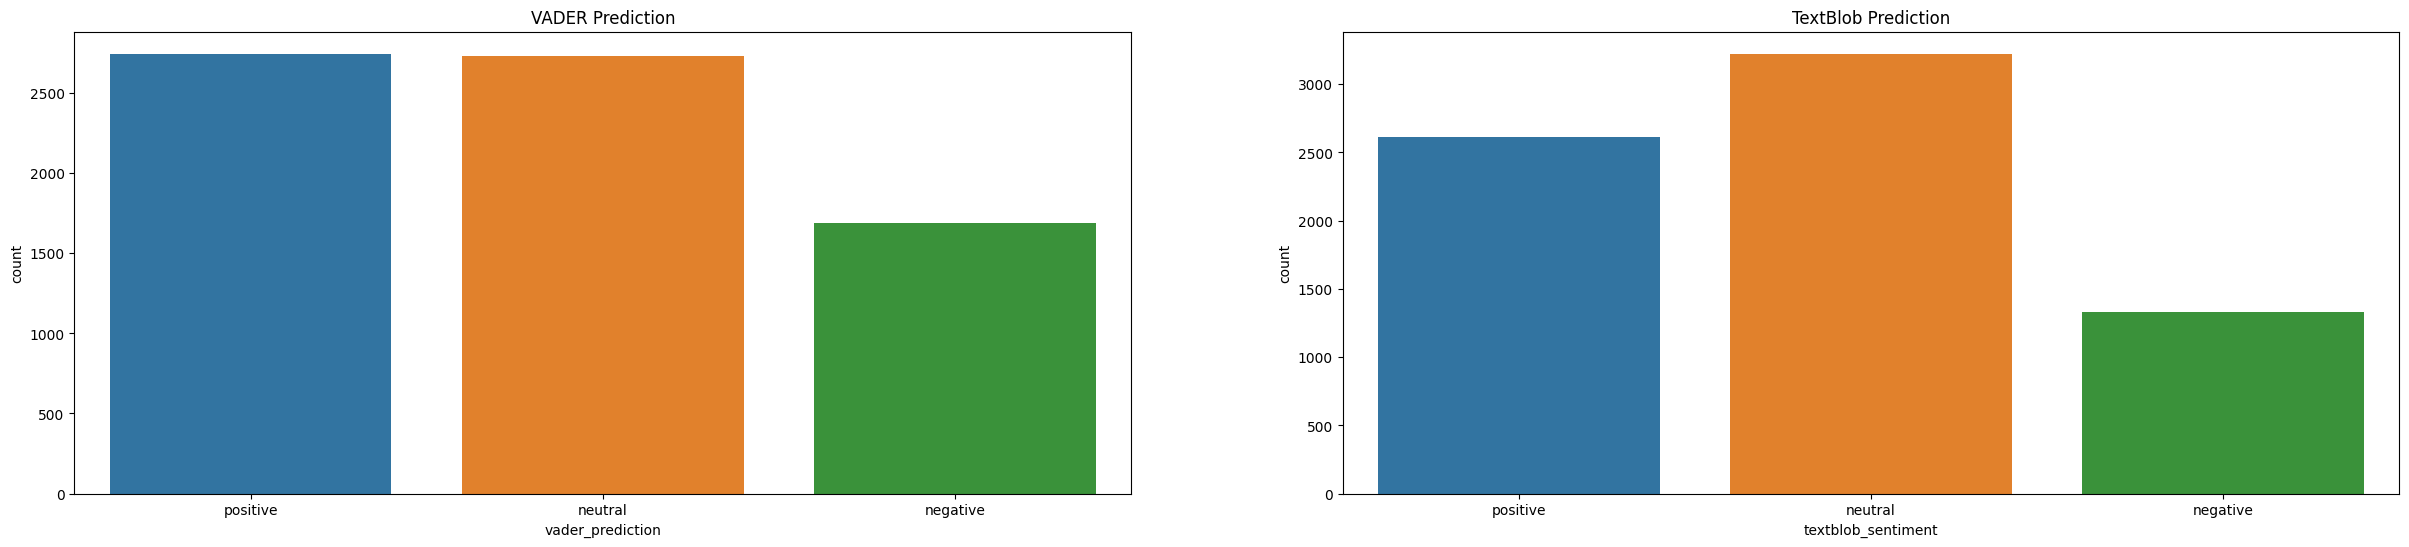

In [107]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(30,6))
sns.countplot(data=european_housing_reddit_df, x='vader_prediction', ax=ax1).set(title="VADER Prediction");
sns.countplot(data=european_housing_reddit_df, x='textblob_sentiment', ax=ax2).set(title="TextBlob Prediction");

### Persist the dataset to MongoDB
Performing API calls to Reddit could result in exceeding the allowed rate limits. A delay was applied before making each GET request to prevent the throttling. When querying large amount of posts/comments, this process can take long time to complete. So, it can be more efficient to regularly persisting the data to a database, and later querying from it instead of using Reddit API all the time.

In [108]:
# Creating MongoDB client and connection
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["ca2"]
# Collection
coll = db['irish_housing_construction']

In [109]:
# Insert the DF rows to MongoDB collection
coll.insert_many(irish_housing_reddit_df.to_dict('records'))

In [110]:
print(f"Estimated documents in MongoDB Collection: {coll.estimated_document_count()}")

Estimated documents in MongoDB Collection: 16197


In [111]:
coll_europe = db['european_housing_construction']

# Insert the DF rows to MongoDB collection
coll_europe.insert_many(european_housing_reddit_df.to_dict('records'))

In [112]:
print(f"Estimated documents in MongoDB Collection: {coll_europe.estimated_document_count()}")

Estimated documents in MongoDB Collection: 7163


### Loading Data from MongoDB to Create Visualization

In [129]:
# Creating MongoDB client and connection
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["ca2"]
# Collection
irish_coll = db['irish_housing_construction']
european_coll = db['european_housing_construction']

In [130]:
# Creating DFs from MongoDB collection
irish_df = pd.DataFrame(list(irish_coll.find()))
european_df = pd.DataFrame(list(european_coll.find()))

In [131]:
irish_df.head()

,_id,created_utc,author,post_id,subreddit,text,vader_prediction,textblob_sentiment
0,645d22dd4d797a0ac207f2de,2023-01-27 09:09:44,tashadaily,10mgkxn,ireland,Right so obviously a burner account.\n\nMy fia...,positive,positive
1,645d22dd4d797a0ac207f2df,2023-01-27 11:15:03,PedantJuice,10mgkxn,ireland,"First; this is perfectly, perfectly human way ...",positive,positive
2,645d22dd4d797a0ac207f2e0,2023-01-27 09:59:22,FullyStacked92,10mgkxn,ireland,The reason your life isn't comfortable on a co...,negative,positive
3,645d22dd4d797a0ac207f2e1,2023-01-27 10:59:06,theriskguy,10mgkxn,ireland,"You’re directing your anger in the wrong, dire...",negative,negative
4,645d22dd4d797a0ac207f2e2,2023-01-27 09:36:50,slice_of_za,10mgkxn,ireland,Sounds like you're having a shitty time of it ...,positive,positive


In [132]:
european_df.head()

,_id,created_utc,author,post_id,subreddit,text,vader_prediction,textblob_sentiment
0,645d22dd4d797a0ac2083223,2021-10-07 18:19:16,DevilSauron,q3f6wi,europe,**The Election**\n\nTomorrow and on Saturday (...,positive,positive
1,645d22dd4d797a0ac2083224,2021-10-14 13:58:01,Plane_Willingness_25,q3f6wi,europe,So how are things developing? Is Babis still g...,neutral,neutral
2,645d22dd4d797a0ac2083225,2021-10-09 22:57:31,linknewtab,q3f6wi,europe,Any chance the new government will finally joi...,positive,positive
3,645d22dd4d797a0ac2083226,2021-10-09 22:55:50,[deleted],q3f6wi,europe,[deleted],neutral,neutral
4,645d22dd4d797a0ac2083227,2021-10-09 22:48:07,Freeman3017,q3f6wi,europe,"Victory day for democracy, this is how it shou...",negative,positive


In [245]:
# Concat the Irish and European DFs, sort by the creation time and reset index to start from 0
reddit_sentiment_df = pd.concat([irish_df, european_df]).sort_values(by=['created_utc']).reset_index(drop=True)
reddit_sentiment_df.head()

,_id,created_utc,author,post_id,subreddit,text,vader_prediction,textblob_sentiment
0,645d22dd4d797a0ac207f983,2010-08-16 20:24:13,el-fish,d1uqp,ireland,In detroit there are companies that deconstruc...,neutral,neutral
1,645d22dd4d797a0ac207f984,2010-08-16 20:31:30,el-fish,d1uqp,ireland,Messed up that submission. Ment to link to thi...,positive,positive
2,645d22dd4d797a0ac207f985,2010-08-16 21:41:27,[deleted],d1uqp,ireland,As a Canadian currently looking for work in Du...,neutral,neutral
3,645d22dd4d797a0ac2083312,2010-12-17 06:42:22,WrigleyJohnson,ena6j,europe,"\nSo, [this thread](http://www.reddit.com/r/eu...",negative,negative
4,645d22dd4d797a0ac2083315,2010-12-17 07:28:02,lavalampmaster,ena6j,europe,"I've spent a lot of time living in both, and I...",negative,negative


In [297]:
# Selecting rows that have common sentiment for Vader and Textblob
reddit_common_sentiment_df = reddit_sentiment_df[reddit_sentiment_df['vader_prediction'] == reddit_sentiment_df['textblob_sentiment']].copy()

# Rename column
reddit_common_sentiment_df.rename(columns={"vader_prediction": "sentiment"}, inplace=True)

# Add columns year and month
reddit_common_sentiment_df['year'] = reddit_common_sentiment_df['created_utc'].dt.year
reddit_common_sentiment_df['month'] = reddit_common_sentiment_df['created_utc'].dt.month.astype('str')
reddit_common_sentiment_df['day'] = reddit_common_sentiment_df['created_utc'].dt.day.astype('str')

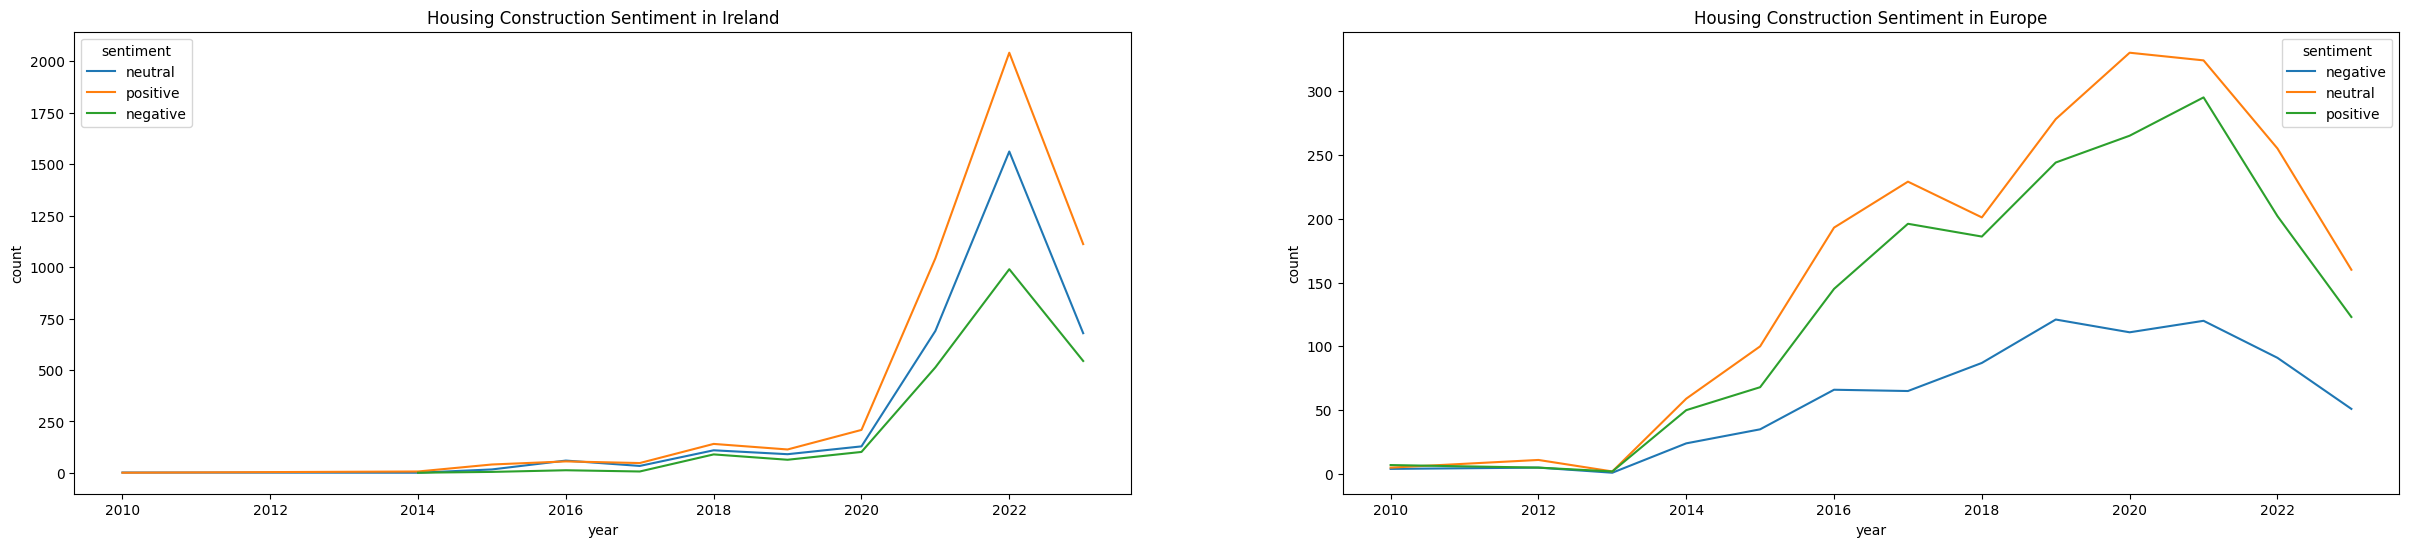

In [298]:
grouped_reddit_df = reddit_common_sentiment_df.groupby(['year', 'subreddit', 'sentiment']).size().reset_index(name="count")

# Plot the line charts for Irish and European datasets
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(30,6))
sns.lineplot(data=grouped_reddit_df[grouped_reddit_df['subreddit']=='ireland'], x='year', y='count', hue='sentiment', ax=ax1).set(title="Housing Construction Sentiment in Ireland");
sns.lineplot(data=grouped_reddit_df[grouped_reddit_df['subreddit']=='europe'], x='year', y='count', hue='sentiment', ax=ax2).set(title="Housing Construction Sentiment in Europe");

In [299]:
grouped_reddit_df = reddit_common_sentiment_df.groupby(['year', 'month', 'day', 'subreddit', 'sentiment']).size().reset_index(name="count")
grouped_reddit_df.head()

,year,month,day,subreddit,sentiment,count
0,2010,12,17,europe,negative,3
1,2010,12,17,europe,neutral,5
2,2010,12,17,europe,positive,7
3,2010,12,18,europe,negative,1
4,2010,8,16,ireland,neutral,2


In [300]:
# Class to be used by Panel
class SentimentAnalysis(param.Parameterized):
    df = grouped_reddit_df
    subreddit = param.Selector(objects=list(df['subreddit'].unique()))
    years = df['year'].unique()
    year  = param.Integer(default=2023, bounds=(int(years[0]), int(years[-1])))

    # Function to plot sentiment
    def plot_sentiment(self, x='month', y='count', hue='sentiment'):
        fig = Figure(figsize=(10,5))
        ax = fig.add_subplot()
        sns.lineplot(data=self.df[(self.df['year']==self.year) & (self.df['subreddit']==self.subreddit)], x=x, y=y, hue=hue, ax=ax)
        ax.set(title=f"Housing Construction Sentiment in {self.subreddit} during {self.year}")
        return fig
    
obj = SentimentAnalysis()
obj

SentimentAnalysis(name='SentimentAnalysis00638', subreddit='europe', year=2023)

Row
    [0] Column(margin=5, name='SentimentAnalysis', width=300)
        [0] StaticText(value='<b>SentimentAnalysis</b>'...)
        [1] Select(name='Subreddit', options=OrderedDict([('europe', ...]), value='europe')
        [2] IntSlider(end=2023, name='Year', start=2010, value=2023)
    [1] ParamMethod(method, _pane=Matplotlib)
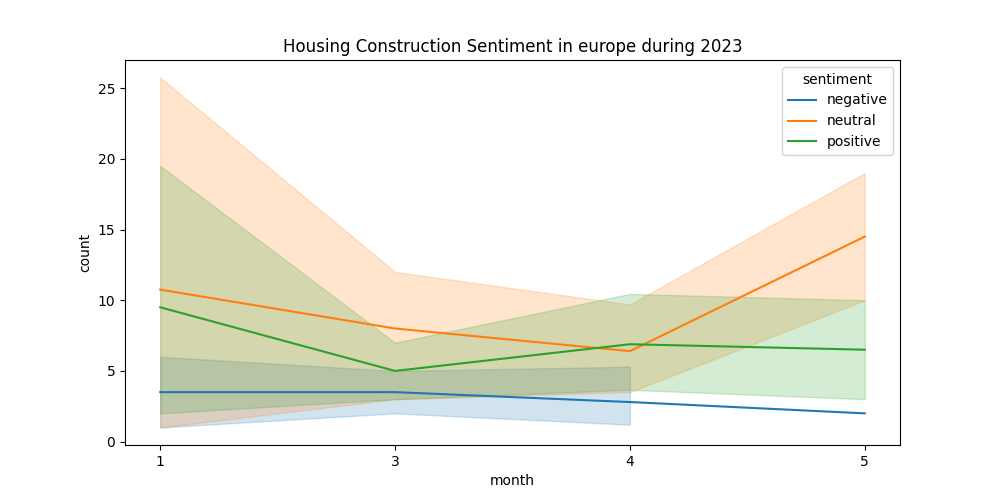

In [301]:
# Display the panel
pn.Row(obj.param, obj.plot_sentiment)

In [294]:
# Class to b used by Panel
class SentimentAnalysis(param.Parameterized):
    df = reddit_common_sentiment_df.copy()
    subreddit = param.Selector(objects=list(df['subreddit'].unique()))
    years = df['year'].unique()
    year  = param.Integer(default=2023, bounds=(int(years[0]), int(years[-1])))
    created_utc = df['created_utc'].values
    date_range = param.CalendarDateRange(
        default = (pd.Timestamp(created_utc[0]), pd.Timestamp(created_utc[-1])),
        bounds = (pd.Timestamp(created_utc[0]), pd.Timestamp(created_utc[-1]))
    )

    # Function to plot sentiment
    def plot_sentiment(self, x='day', y='count', hue='sentiment'):
        fig = Figure(figsize=(10,5))
        ax = fig.add_subplot()
        # Filter the data between start date and end date
        data = self.df[(self.df['created_utc'] >= self.date_range[0]) & (self.df['created_utc'] <= self.date_range[1]) & (self.df['subreddit']==self.subreddit)]
        
        # Add column for day
        data['day'] = self.df['created_utc'].dt.to_period('D').astype('str')
        
        # Group data and count the records
        data = data.groupby(['day', 'subreddit', 'sentiment']).size().reset_index(name="count")
#         data['date'] = data.apply(lambda x: '-'.join([x['year'], x['month'], x['day']]))
        
        # Plot the final data
        sns.lineplot(data=data, x=x, y=y, hue=hue, ax=ax)
        ax.set(title=f"Housing Construction Sentiment in {self.subreddit} during {self.year}")
        return fig
    
obj = SentimentAnalysis()
obj

SentimentAnalysis(date_range=(Timestamp('2010-08-16 20:24:13'), Timestamp('2023-05-11 07:57:13')), name='SentimentAnalysis00617', subreddit='ireland', year=2023)

/var/folders/_4/72grbz3j17n4zqnmhsn0cdyh0000gs/T/ipykernel_6164/72051698.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = self.df['created_utc'].dt.to_period('D').astype('str')


Row
    [0] Column(margin=5, name='SentimentAnalysis', width=300)
        [0] StaticText(value='<b>SentimentAnalysis</b>'...)
        [1] Select(name='Subreddit', options=OrderedDict([('ireland', ...]), value='ireland')
        [2] IntSlider(end=2023, name='Year', start=2010, value=2023)
        [3] DateRangeSlider(end=Timestamp('2023-05-11 0..., name='Date range', start=Timestamp('2010-08-16 2..., value=(Timestamp('2010-08-16 20:..., value_end=Timestamp('2023-05-11 0..., value_start=Timestamp('2010-08-16 2...)
    [1] ParamMethod(method, _pane=Matplotlib)
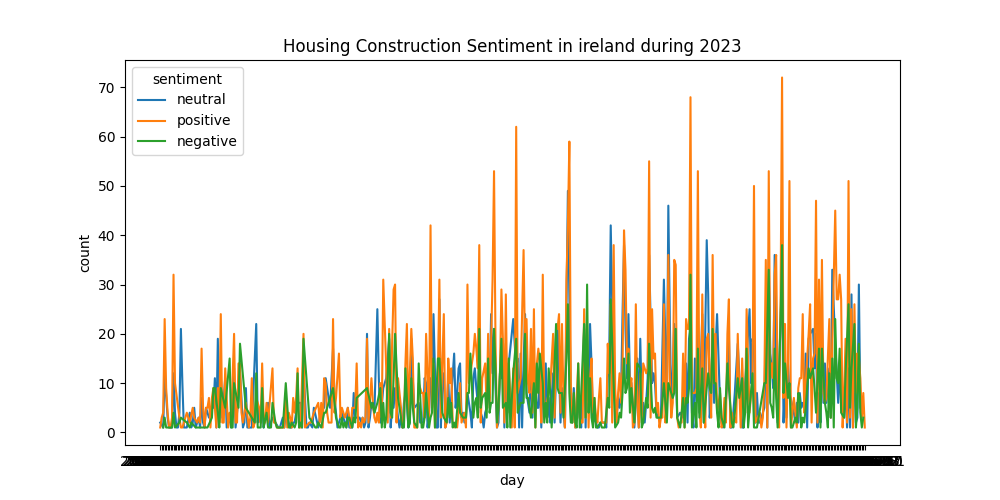

In [295]:
# Display the panel
pn.Row(obj.param, obj.plot_sentiment)

In [293]:
type(reddit_common_sentiment_df['created_utc'].dt.to_period('D')[0])

pandas._libs.tslibs.period.Period

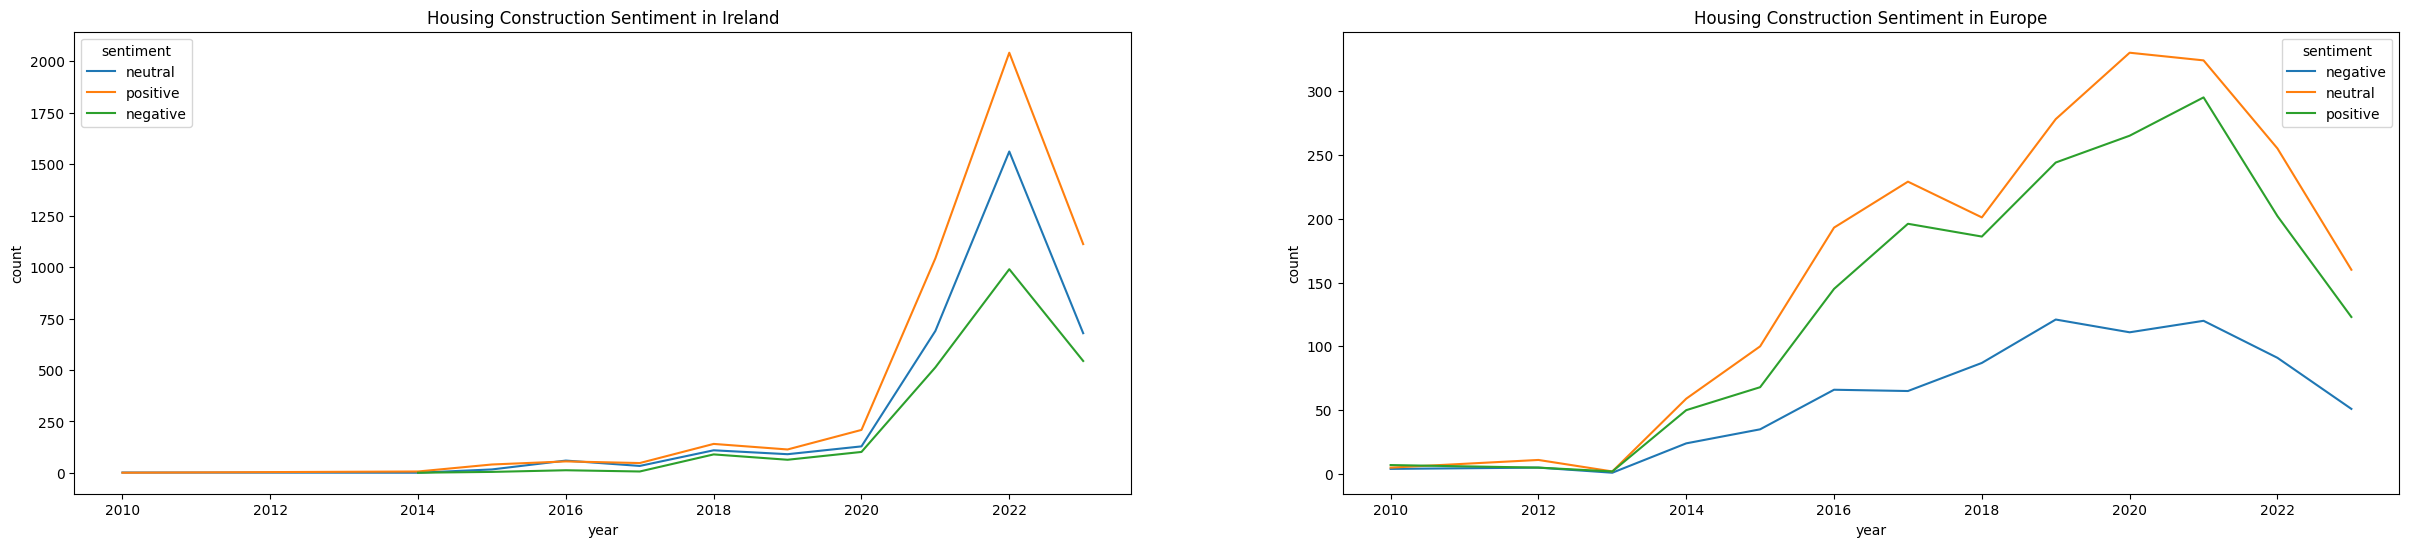

In [133]:
# Selecting rows that have common sentiment for Vader and Textblob
irish_housing_common_sentiment_df = irish_df[irish_df['vader_prediction'] == irish_df['textblob_sentiment']].copy()
european_housing_common_sentiment_df = european_df[european_df['vader_prediction'] == european_df['textblob_sentiment']].copy()

# Rename column
irish_housing_common_sentiment_df.rename(columns={"vader_prediction": "sentiment"}, inplace=True)
european_housing_common_sentiment_df.rename(columns={"vader_prediction": "sentiment"}, inplace=True)

# Add column for year
irish_housing_common_sentiment_df['year'] = irish_housing_common_sentiment_df['created_utc'].dt.year
european_housing_common_sentiment_df['year'] = european_housing_common_sentiment_df['created_utc'].dt.year

# Group by year and sentiment, and count the records in each group 
grouped_irish_df = irish_housing_common_sentiment_df.groupby(['year', 'sentiment']).size().reset_index(name="count")
grouped_european_df = european_housing_common_sentiment_df.groupby(['year', 'sentiment']).size().reset_index(name="count")

# Plot the line charts for Irish and European datasets
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(30,6))
sns.lineplot(data=grouped_irish_df, x='year', y='count', hue='sentiment', ax=ax1).set(title="Housing Construction Sentiment in Ireland");
sns.lineplot(data=grouped_european_df, x='year', y='count', hue='sentiment', ax=ax2).set(title="Housing Construction Sentiment in Europe");

In [175]:
# Add column for month
irish_housing_common_sentiment_df['month'] = irish_housing_common_sentiment_df['created_utc'].dt.month.astype('str')   #.to_period('M').astype('str')
european_housing_common_sentiment_df['month'] = european_housing_common_sentiment_df['created_utc'].dt.month.astype('str')   #.to_period('M').astype('str')

# Group by month and sentiment, and count the records in each group 
grouped_irish_df = irish_housing_common_sentiment_df.groupby(['year', 'month', 'sentiment']).size().reset_index(name="count")
grouped_european_df = european_housing_common_sentiment_df.groupby(['year', 'month', 'sentiment']).size().reset_index(name="count")

In [176]:
grouped_european_df.head()

,year,month,sentiment,count
0,2010,12,negative,4
1,2010,12,neutral,5
2,2010,12,positive,7
3,2012,10,negative,1
4,2012,10,neutral,5


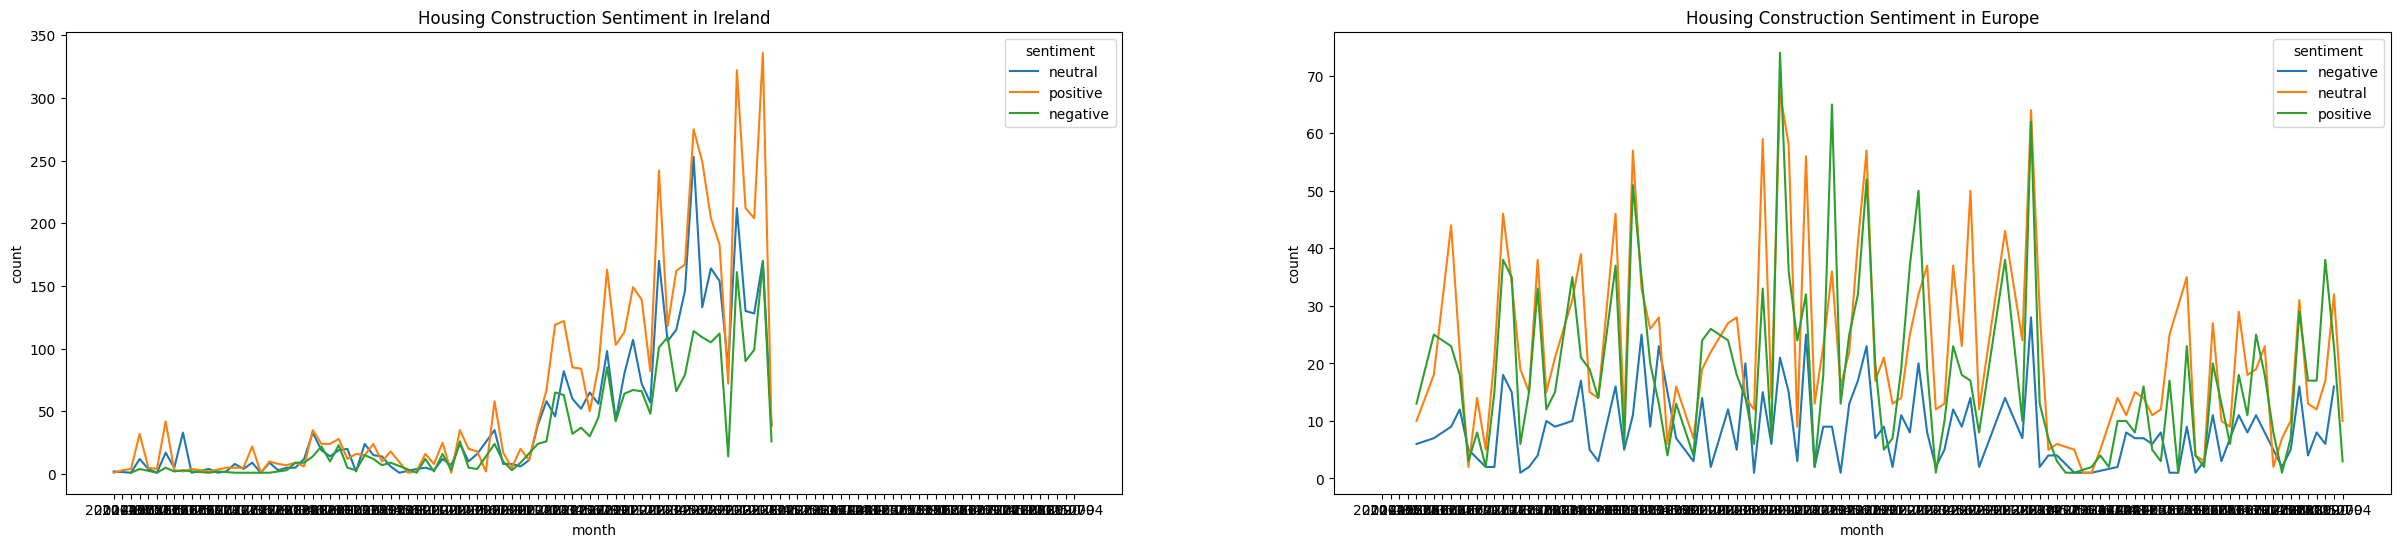

In [151]:
# Plot the line charts for Irish and European datasets
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(30,6))
sns.lineplot(data=grouped_irish_df, x='month', y='count', hue='sentiment', ax=ax1).set(title="Housing Construction Sentiment in Ireland");
sns.lineplot(data=grouped_european_df, x='month', y='count', hue='sentiment', ax=ax2).set(title="Housing Construction Sentiment in Europe");

In [172]:
def plot_sentiment(year='2023', x='month', y='count', hue='sentiment'):
    fig = Figure()
    ax = fig.add_subplot()
    sns.lineplot(data=grouped_irish_df[grouped_irish_df['year']==year], x=x, y=y, hue=hue, ax=ax)
    ax.set(title="Housing Construction Sentiment in Ireland")
    return fig

# plot_sentiment('month', 'count', 'sentiment')

Column
    [0] Column()
    [1] Row
        [0] Matplotlib(Figure, height=345, name='interactive00101', width=460)
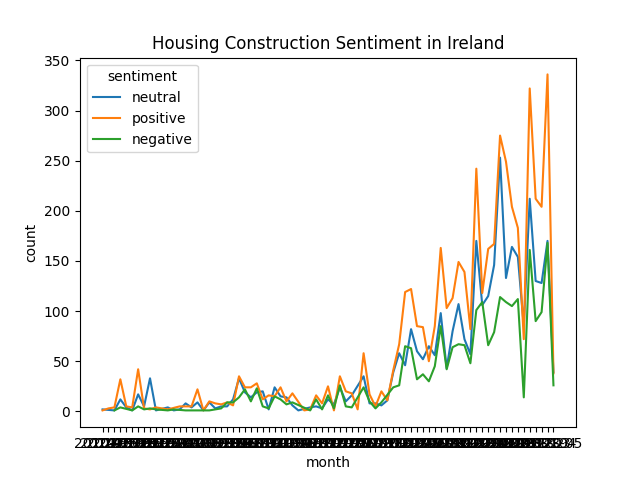

In [165]:
pn.extension()
pn.interact(plot_sentiment)

In [168]:
kw = dict(window=(1, 60), variable=sorted(list(grouped_irish_df.columns)), sigma=(1, 20))
i = pn.interact(plot_sentiment, **kw)
i.pprint()

Column
    [0] Column()
    [1] Row
        [0] Matplotlib(Figure, name='interactive00122')


/var/folders/_4/72grbz3j17n4zqnmhsn0cdyh0000gs/T/ipykernel_6164/3364841234.py:3: PanelDeprecationWarning: 'Column.pprint' is deprecated and will be removed in version 1.0, use 'print' instead.
  i.pprint()


In [179]:
class SentimentAnalysis(param.Parameterized):
#     year  = param.Selector(objects=list(grouped_irish_df['year'].unique()))
    years = grouped_irish_df['year'].unique()
    year  = param.Integer(default=2023, bounds=(int(years[0]), int(years[-1])))

    def view(self):
        return plot_sentiment(self.year)
    
obj = SentimentAnalysis()
obj

SentimentAnalysis(name='SentimentAnalysis00154', year=2023)

Row
    [0] Column(margin=5, name='SentimentAnalysis', width=300)
        [0] StaticText(value='<b>SentimentAnalysis</b>'...)
        [1] IntSlider(end=2023, name='Year', start=2010, value=2023)
    [1] ParamMethod(method, _pane=Matplotlib)
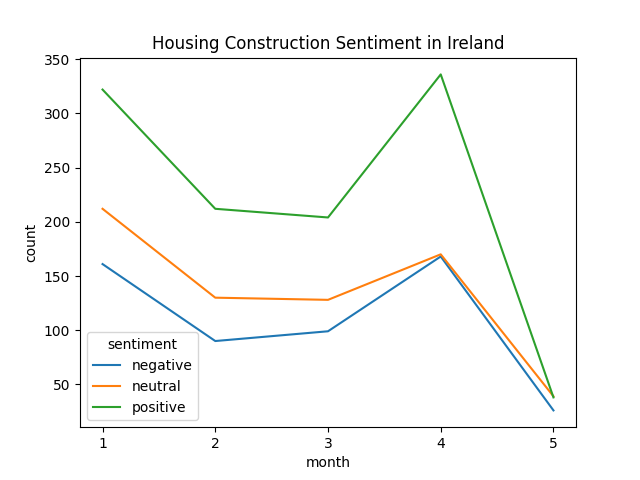

In [180]:
pn.Row(obj.param, obj.view)